# Imports

In [205]:

import tensorflow as tf
import pandas as pd
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics.pairwise import cosine_distances

from collections import Counter
import wordcloud
import string

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px


In [206]:
# Je donne accès à colab à mon drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import dataset

In [207]:
#Importation du dataset provenant d'un fichier csv
#création d'un data frame pandas avec le dataset
df = pd.read_csv('/content/drive/MyDrive/jedha/Projets/sample-data_north_face.csv')
df.head()

id                                        description
0   1  Active classic boxers - There's a reason why o...
1   2  Active sport boxer briefs - Skinning up Glory ...
2   3  Active sport briefs - These superbreathable no...
3   4  Alpine guide pants - Skin in, climb ice, switc...
4   5  Alpine wind jkt - On high ridges, steep ice an...

In [208]:
liste_mots = df['description'].apply(lambda x:str(x).split())
top = Counter([item for sublist in liste_mots for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

# Preprocessing


Remove punctuation and lower case the whole text
We only keep alphnumeric characters

In [209]:
# Remove punctuation and lower case the whole text
df['description_clean'] = df['description'].str.replace(r"[!\"#$%&()*+,-./:;<=>?@[\\\]^_`{|}~]+", " ")
df['description_clean'] = df['description_clean'].fillna('').apply(lambda x: x.lower())

df.head()


id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                                   description_clean  
0  active classic boxers - there's a reason why o...  
1  active sport boxer briefs - skinning up glory ...  
2  active sport briefs - these superbreathable no...  
3  alpine guide pants - skin in, climb ice, switc...  
4  alpine wind jkt - on high ridges, steep ice an...

We keep some verbs abbreviations that will then treated as STOP WORS

In [210]:
# List of exceptions
exceptions = [
    "'d", "'ll", "'m", "'re", "'s", "'ve",
    "‘d", "‘ll", "‘m", "‘re", "‘s", "‘ve",
    "’d", "’ll", "’m", "’re", "’s", "’ve"
]

# Define a function to clean descriptions
def clean_description(desc):
    words = desc.split()
    cleaned_words = []

    for word in words:
        # Check if the word is alphanumeric or in exceptions
        if word.isalnum() or any(word.endswith(exc) for exc in exceptions):
            cleaned_words.append(word)

    return ' '.join(cleaned_words)

# Apply the cleaning function to the description_clean column
df['description_clean'] = df['description_clean'].apply(clean_description)


In [211]:
df.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                                   description_clean  
0  active classic boxers there's a reason why our...  
1  active sport boxer briefs skinning up glory re...  
2  active sport briefs these superbreathable brie...  
3  alpine guide pants skin climb switch to traver...  
4  alpine wind jkt on high steep ice and anything...

Import spacy's englsh model

In [212]:

import en_core_web_sm
# Import english stop words
from spacy.lang.en.stop_words import STOP_WORDS
nlp = en_core_web_sm.load()

Tokenization

In [213]:
df['description_clean'] = df['description_clean'].apply(lambda x: nlp(x))
df.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                                   description_clean  
0  (active, classic, boxers, there, 's, a, reason...  
1  (active, sport, boxer, briefs, skinning, up, g...  
2  (active, sport, briefs, these, superbreathable...  
3  (alpine, guide, pants, skin, climb, switch, to...  
4  (alpine, wind, jkt, on, high, steep, ice, and,...

In [214]:
df['description_token'] = df['description_clean'].apply(lambda x: [token.text for token in x if token.text not in STOP_WORDS])
df['description_lemma'] = df['description_clean'].apply(lambda x:[token.lemma_ for token in x if token.lemma_ not in STOP_WORDS])
df.head()



id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                                   description_clean  \
0  (active, classic, boxers, there, 's, a, reason...   
1  (active, sport, boxer, briefs, skinning, up, g...   
2  (active, sport, briefs, these, superbreathable...   
3  (alpine, guide, pants, skin, climb, switch, to...   
4  (alpine, wind, jkt, on, high, steep, ice, and,...   

                                   description_token  \
0  [active, classic, boxers, reason, boxers, cult...   
1  [active, sport, boxer, briefs, skinning, glory...   
2  [active, sport, briefs, superbreathable, brief...   
3  [alpine, guide, pants, skin, climb, switch, tr...   
4  [alpine, wind, jkt, high, steep, ice, jacket, ...   

                                   description_lemma  
0  [active, classic, boxer, reason, boxer, cult, ...  
1  [active, sport, boxer, brief, skin, glory, req...  
2  [active, sport, brief, superbreathable, brief,...  
3  [alpine, guide, pant, skin, climb, switch, tra...  
4  [alpine, wind, jkt, high, steep, ice, jacket, ...

In [215]:
df["clean_token"] = [" ".join(x) for x in df['description_lemma']]
df.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                                   description_clean  \
0  (active, classic, boxers, there, 's, a, reason...   
1  (active, sport, boxer, briefs, skinning, up, g...   
2  (active, sport, briefs, these, superbreathable...   
3  (alpine, guide, pants, skin, climb, switch, to...   
4  (alpine, wind, jkt, on, high, steep, ice, and,...   

                                   description_token  \
0  [active, classic, boxers, reason, boxers, cult...   
1  [active, sport, boxer, briefs, skinning, glory...   
2  [active, sport, briefs, superbreathable, brief...   
3  [alpine, guide, pants, skin, climb, switch, tr...   
4  [alpine, wind, jkt, high, steep, ice, jacket, ...   

                                   description_lemma  \
0  [active, classic, boxer, reason, boxer, cult, ...   
1  [active, sport, boxer, brief, skin, glory, req...   
2  [active, sport, brief, superbreathable, brief,...   
3  [alpine, guide, pant, skin, climb, switch, tra...   
4  [alpine, wind, jkt, high, steep, ice, jacket, ...   

                                         clean_token  
0  active classic boxer reason boxer cult favorit...  
1  active sport boxer brief skin glory require mo...  
2  active sport brief superbreathable brief minim...  
3  alpine guide pant skin climb switch traverse r...  
4  alpine wind jkt high steep ice jacket serve tr...

In [216]:
texts = df['clean_token']
texts

0      active classic boxer reason boxer cult favorit...
1      active sport boxer brief skin glory require mo...
2      active sport brief superbreathable brief minim...
3      alpine guide pant skin climb switch traverse r...
4      alpine wind jkt high steep ice jacket serve tr...
                             ...                        
495    cap 2 cut loose madden crowd search capilene 2...
496    cap 2 crew crew edge fickle clearing fast dry ...
497    shell need use morning time handsome recycle p...
498    cargo short cargo short bask glory sweat paint...
499    short time short prove short comfortable organ...
Name: clean_token, Length: 500, dtype: object

Visualization: most frequent words after preprocessing inclusing the withdrawal of stop words.

In [217]:
liste_mots = df['clean_token'].apply(lambda x:str(x).split())
top = Counter([item for sublist in liste_mots for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

Vectorization on the texts variable which gathers df['clean_token']

In [218]:
# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(texts)

# X is a generator. We can transform that as an array
dense = X.toarray()
dense.shape

(500, 2941)

In [219]:
df_tf_idf = pd.DataFrame(dense, columns = [x for x in vectorizer.get_feature_names_out()])

df_tf_idf.columns

Index(['10', '100', '11', '12', '13', '14', '15', '156', '16', '168',
       ...
       'yoke', 'yosemite', 'young', 'yvon', 'zest', 'zinger', 'zip', 'zipper',
       'zippered', 'zone'],
      dtype='object', length=2941)

# Part 1 : Groups of products with similar descriptions


Training of a clustering model

DBSCAN

In [220]:
db = DBSCAN(eps=0.7, min_samples=5, metric="cosine", algorithm="brute")

# Fit on data
db.fit(dense)

DBSCAN(algorithm='brute', eps=0.7, metric='cosine')

In [221]:
# Loop through each label for our cluster
for i in np.unique(db.labels_):
    label = dense[db.labels_ == i]

    # Debugging print to check the number of points in each cluster
    print(f"Cluster {i}: {label.shape[0]} points")

Cluster -1: 146 points
Cluster 0: 45 points
Cluster 1: 172 points
Cluster 2: 21 points
Cluster 3: 22 points
Cluster 4: 8 points
Cluster 5: 8 points
Cluster 6: 6 points
Cluster 7: 24 points
Cluster 8: 9 points
Cluster 9: 7 points
Cluster 10: 5 points
Cluster 11: 7 points
Cluster 12: 7 points
Cluster 13: 6 points
Cluster 14: 7 points


In [222]:
df['cluster'] = db.labels_
df.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                                   description_clean  \
0  (active, classic, boxers, there, 's, a, reason...   
1  (active, sport, boxer, briefs, skinning, up, g...   
2  (active, sport, briefs, these, superbreathable...   
3  (alpine, guide, pants, skin, climb, switch, to...   
4  (alpine, wind, jkt, on, high, steep, ice, and,...   

                                   description_token  \
0  [active, classic, boxers, reason, boxers, cult...   
1  [active, sport, boxer, briefs, skinning, glory...   
2  [active, sport, briefs, superbreathable, brief...   
3  [alpine, guide, pants, skin, climb, switch, tr...   
4  [alpine, wind, jkt, high, steep, ice, jacket, ...   

                                   description_lemma  \
0  [active, classic, boxer, reason, boxer, cult, ...   
1  [active, sport, boxer, brief, skin, glory, req...   
2  [active, sport, brief, superbreathable, brief,...   
3  [alpine, guide, pant, skin, climb, switch, tra...   
4  [alpine, wind, jkt, high, steep, ice, jacket, ...   

                                         clean_token  cluster  
0  active classic boxer reason boxer cult favorit...        0  
1  active sport boxer brief skin glory require mo...        0  
2  active sport brief superbreathable brief minim...        0  
3  alpine guide pant skin climb switch traverse r...        1  
4  alpine wind jkt high steep ice jacket serve tr...        2

### Visualization of the clusters

In [258]:
fig = px.scatter(df, x="id", y="cluster", color="cluster",
                 title="Clusters by ID")

fig.show()

Number of clusters and outliers/noise elements count according to the model:

In [224]:
no_clusters = len(np.unique(db.labels_) )
no_noise = np.sum(np.array(db.labels_) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 16
Estimated no. of noise points: 146


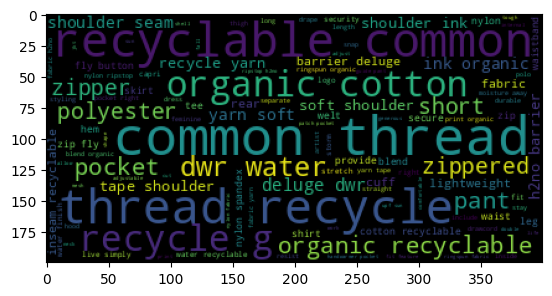

In [225]:
wd = wordcloud.WordCloud()

text = " ".join(df[df['cluster'] == 1]['clean_token'])
cloud = wd.generate(text)
plt.imshow(cloud)

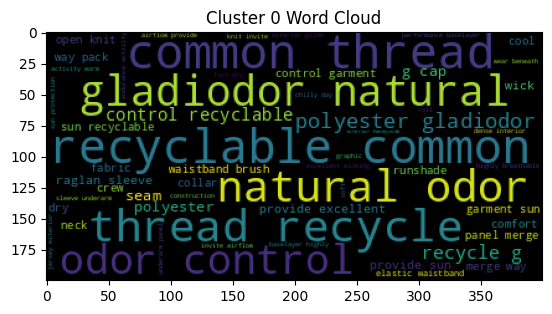

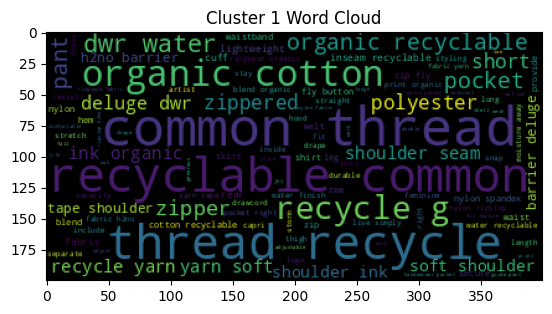

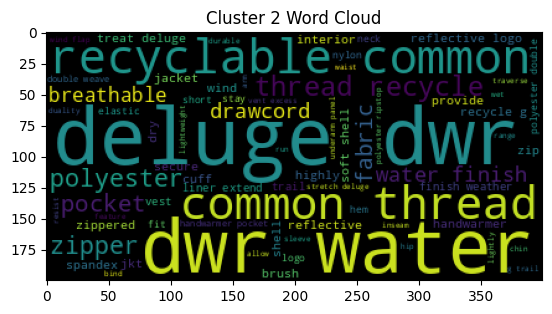

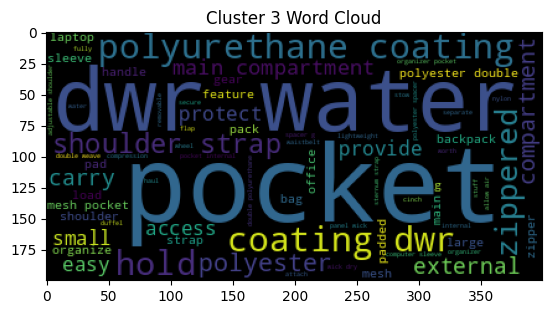

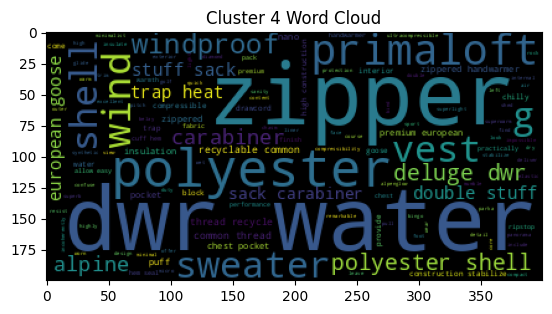

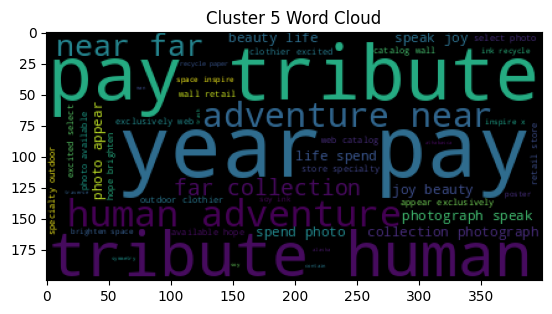

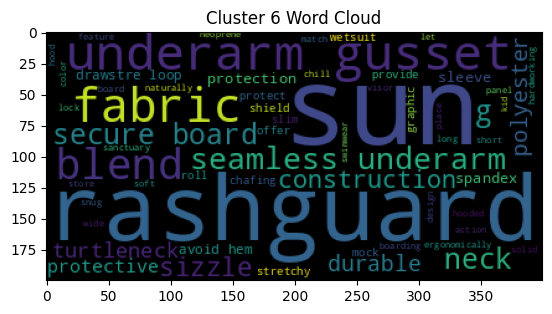

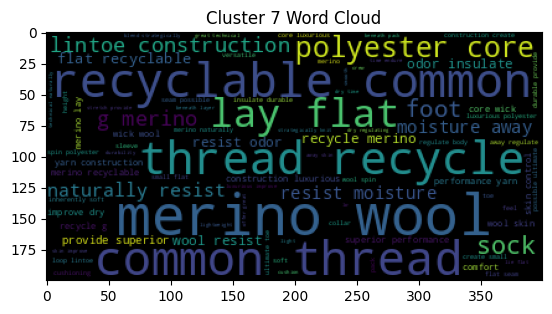

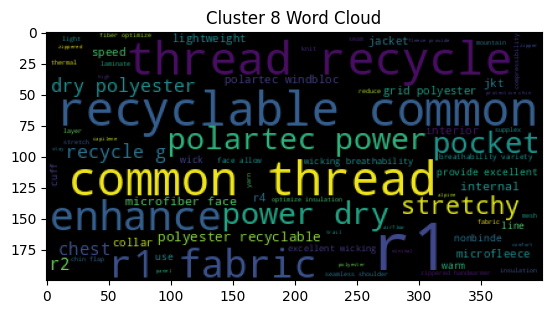

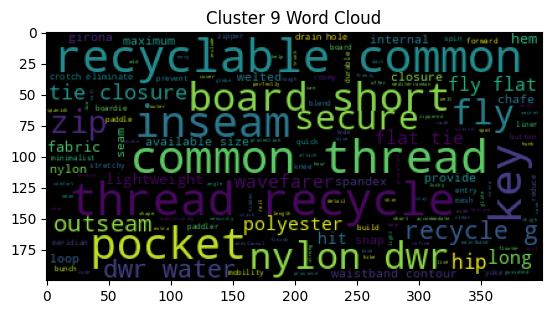

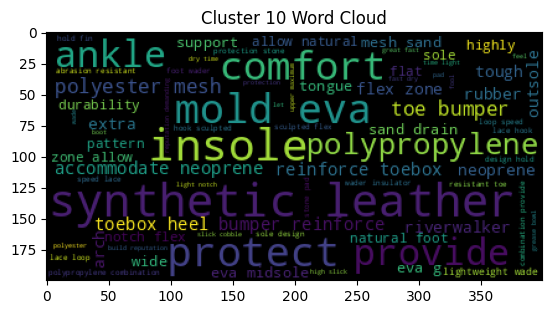

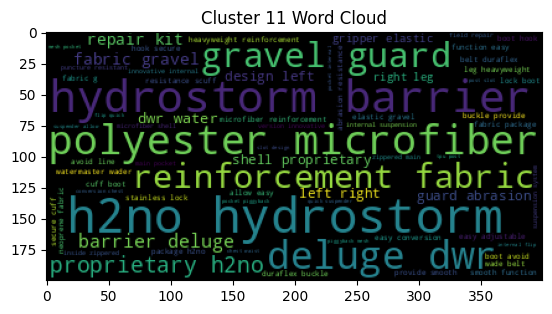

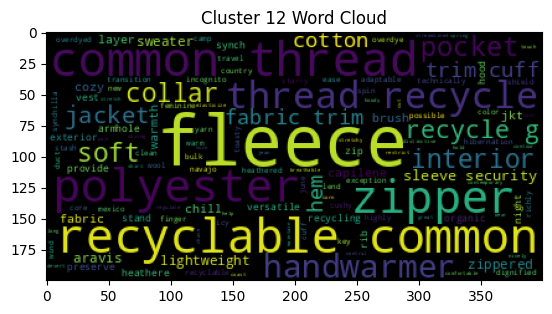

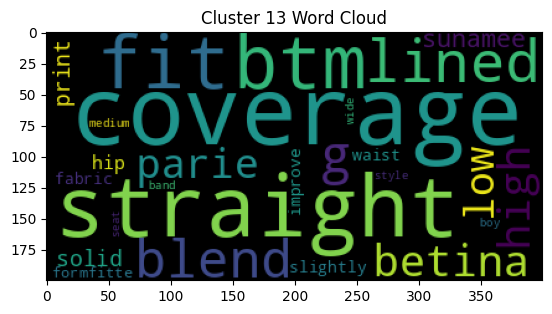

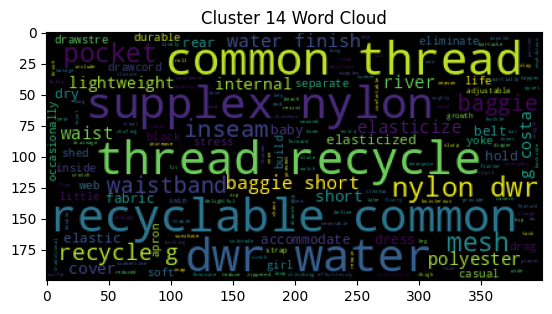

In [226]:
wd = wordcloud.WordCloud()

# A function to create a worldcloud for an specific cluster
def plot_wordcloud(cluster):
    texts = " ".join(df[df['cluster'] == cluster]['clean_token'])
    cloud = wd.generate(texts)
    plt.title(f'Cluster {cluster} Word Cloud')
    plt.imshow(cloud)
    plt.show()

# Generate word clouds for each cluster
#On aplique la function à chaque cluster avec une boucle for
unique_clusters = sorted(df['cluster'].unique())
for cluster in unique_clusters:
    if cluster != -1:
      cluster_text = df[df['cluster'] == cluster]['clean_token']
      plot_wordcloud(cluster)


# RECOMMENDER SYSTEM


 We will create a function named `find_similar_items` that takes an argument that recommends a similar product to the user

In [227]:
data = df[df['id'] == 5]['cluster']

In [228]:
data.iloc[0]

2

In [229]:
df.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                                   description_clean  \
0  (active, classic, boxers, there, 's, a, reason...   
1  (active, sport, boxer, briefs, skinning, up, g...   
2  (active, sport, briefs, these, superbreathable...   
3  (alpine, guide, pants, skin, climb, switch, to...   
4  (alpine, wind, jkt, on, high, steep, ice, and,...   

                                   description_token  \
0  [active, classic, boxers, reason, boxers, cult...   
1  [active, sport, boxer, briefs, skinning, glory...   
2  [active, sport, briefs, superbreathable, brief...   
3  [alpine, guide, pants, skin, climb, switch, tr...   
4  [alpine, wind, jkt, high, steep, ice, jacket, ...   

                                   description_lemma  \
0  [active, classic, boxer, reason, boxer, cult, ...   
1  [active, sport, boxer, brief, skin, glory, req...   
2  [active, sport, brief, superbreathable, brief,...   
3  [alpine, guide, pant, skin, climb, switch, tra...   
4  [alpine, wind, jkt, high, steep, ice, jacket, ...   

                                         clean_token  cluster  
0  active classic boxer reason boxer cult favorit...        0  
1  active sport boxer brief skin glory require mo...        0  
2  active sport brief superbreathable brief minim...        0  
3  alpine guide pant skin climb switch traverse r...        1  
4  alpine wind jkt high steep ice jacket serve tr...        2

In [241]:
print(df[df['cluster'] == -1]['description'].str.split('-').str[0].sample(5).tolist())

['Velocity visor ', 'Riverwalker vest ', 'Solid bibiana top ', 'L/s gravi', "Girl's boardie capris "]


In [242]:
print(df[df['cluster'] == -1]['id'].tolist())

[9, 10, 11, 13, 17, 30, 33, 38, 39, 40, 43, 44, 45, 46, 47, 49, 50, 51, 53, 54, 57, 62, 66, 70, 74, 76, 78, 99, 101, 103, 111, 112, 121, 122, 123, 125, 126, 127, 129, 131, 133, 134, 135, 137, 140, 142, 145, 149, 151, 156, 157, 158, 160, 163, 164, 165, 177, 180, 181, 182, 183, 198, 199, 205, 206, 215, 218, 219, 221, 222, 225, 227, 228, 231, 233, 240, 241, 242, 243, 244, 246, 247, 252, 253, 257, 258, 271, 272, 273, 278, 283, 285, 286, 290, 291, 292, 293, 295, 301, 304, 316, 317, 318, 320, 337, 342, 344, 349, 356, 357, 358, 362, 368, 369, 370, 374, 377, 388, 400, 404, 405, 409, 410, 411, 412, 417, 419, 422, 425, 426, 431, 434, 435, 439, 448, 449, 451, 459, 460, 461, 472, 474, 475, 478, 479, 492]


Function for similar products recommendation

In [245]:
def find_cluster():
  item_id = input("Enter item ID: ") #input function so that user can insert the item id
  item_id = int(item_id)  #ensure the item id is an integer

  if item_id in df['id'].values and df[df['id'] == item_id]['cluster' !=-1]:   #if the item id insert is in the database, the function will look for the value in the corresponding cluster column

        cluster_num = df[df['id'] == item_id]['cluster'].iloc[0]
        item_name = df[df['id'] == item_id]['description'].iloc[0].split('-')[0]


        recommended_products = df[df['cluster'] == cluster_num]['description'].str.split('-').str[0].sample(5).tolist()# we create a list of 5 similar items randomly selected through the cluster number

        if item_name in recommended_products:  #we prevent the customer's item to being recommended again
          recommended_products.remove(item_name)


        print(f'Cluster number: {cluster_num}') #we obtain the cluster number of the item inserted
        print(f'Other products you may like:', (', '.join(recommended_products)))

  if item_id in df['id'].values and df[df['id'] == item_id]['cluster' ==-1]:
    print(f'Id {item_id} has no similar items')

  else:
        print(f'Id {item_id} not found in the database')

In [251]:
def find_cluster():
    item_id = input("Enter item ID: ")  # input function so that user can insert the item id
    item_id = int(item_id)  # ensure the item id is an integer

    if item_id in df['id'].values:
        cluster_value = df[df['id'] == item_id]['cluster'].iloc[0]

        if cluster_value != -1:  # if cluster is not -1
            cluster_num = cluster_value
            item_name = df[df['id'] == item_id]['description'].iloc[0].split('-')[0]

            # Create a list of 5 similar items randomly selected through the cluster number
            recommended_products = df[df['cluster'] == cluster_num]['description'].str.split('-').str[0].sample(5).tolist()

            # Prevent the customer's item from being recommended again
            if item_name in recommended_products:
                recommended_products.remove(item_name)

            print(f'Cluster number: {cluster_num}')  # Obtain the cluster number of the item inserted
            print(f'Other products you may like:', (', '.join(recommended_products)))

        else:  # if cluster is -1
            print(f'Id {item_id} has no similar items')

    else:
        print(f'Id {item_id} not found in the database')


Example

In [257]:
find_cluster()

Enter item ID: 2
Cluster number: 0
Other products you may like: Active briefs , Active classic boxers , Cap 1 t, Active boxer briefs 


#Part 3
#Topic modeling

### We will apply a TruncatedSVD to make topic extraction from the products descriptions.

### The model will be apply of the already TF-IDF matrix of the products description obtained through scikit leanr's TfidfVectorizer

Model:

In [233]:
#X is already vectorized

svd_model = TruncatedSVD(n_components=15, n_iter=100, random_state=0)
lsa = svd_model.fit_transform(X)

n_components = 15

In [234]:


#On crée un dataframe avec tous les differents sujets identifiées
#On crée les noms des colonnes pour chaque sujet à travers une comprehesion list
#On ajoute une dernière colonne avec les observations (le texte analysé par le modèle)

topic_encoded_df = pd.DataFrame(lsa, columns = ['topic_'  + str(x) for x in range(1,16)])

topic_encoded_df["clean_token"] = df['clean_token']
topic_encoded_df["description"] = df['description']


topic_encoded_df.head()

topic_1   topic_2   topic_3   topic_4   topic_5   topic_6   topic_7  \
0  0.216117 -0.036488  0.145529 -0.100053 -0.100543  0.011457 -0.010175   
1  0.230019 -0.054329  0.064959 -0.005300 -0.086005 -0.050833  0.022129   
2  0.242048 -0.058487  0.056640 -0.023123 -0.036364 -0.075803 -0.022291   
3  0.322820 -0.214601 -0.121748  0.015903  0.020876  0.089103  0.061298   
4  0.311194 -0.280298 -0.047816 -0.082779  0.097649  0.147093  0.006807   

    topic_8   topic_9  topic_10  topic_11  topic_12  topic_13  topic_14  \
0  0.063790 -0.078486  0.098318 -0.065903 -0.025513 -0.002685 -0.039934   
1  0.006082 -0.034718  0.080672 -0.147602 -0.046470  0.061304 -0.067861   
2 -0.037954  0.052000  0.040405 -0.150936 -0.026934  0.077699 -0.026007   
3  0.058218 -0.155627 -0.039768 -0.029259 -0.006384  0.032472  0.019483   
4  0.006852 -0.060572 -0.125195 -0.113966  0.019388 -0.030464  0.033667   

   topic_15                                        clean_token  \
0  0.014447  active classic boxer reason boxer cult favorit...   
1 -0.030437  active sport boxer brief skin glory require mo...   
2 -0.007623  active sport brief superbreathable brief minim...   
3  0.011314  alpine guide pant skin climb switch traverse r...   
4  0.226110  alpine wind jkt high steep ice jacket serve tr...   

                                         description  
0  Active classic boxers - There's a reason why o...  
1  Active sport boxer briefs - Skinning up Glory ...  
2  Active sport briefs - These superbreathable no...  
3  Alpine guide pants - Skin in, climb ice, switc...  
4  Alpine wind jkt - On high ridges, steep ice an...

We extract the index of the max values for each topic in the dataframe

In [235]:
index_max_value = []

topics_columns_list = ['topic_'  + str(x) for x in range(1,16)]
for i in topics_columns_list:
  index_max = topic_encoded_df[i].idxmax()
  #index_max_value = index_max_value.append(index_max_value)
  index_max_value.append(index_max)


In [236]:
index_max_value

[72, 490, 406, 405, 469, 273, 76, 237, 76, 153, 486, 432, 105, 338, 363]

Dataframe with max value per topic and its corresponding index in the dataframe gathering all the items.

In [237]:

max_index_topic = topic_encoded_df.loc[index_max_value]

max_index_topic.head()


topic_1   topic_2   topic_3   topic_4   topic_5   topic_6   topic_7  \
72   0.421706  0.384320  0.037319 -0.123218  0.311005 -0.067789  0.077145   
490  0.416952  0.417881  0.004780 -0.080970  0.343184 -0.130539  0.107310   
406  0.292780 -0.068768  0.572204  0.552323  0.111355  0.011744  0.008470   
405  0.275569 -0.094331  0.527539  0.631194  0.071779  0.028881  0.036470   
469  0.318550  0.356260  0.019356 -0.112888  0.360741 -0.069620  0.163435   

      topic_8   topic_9  topic_10  topic_11  topic_12  topic_13  topic_14  \
72   0.001213 -0.028370  0.026079  0.030411  0.052250 -0.004787  0.030931   
490  0.055705 -0.101395  0.100040  0.013434 -0.152618 -0.053148  0.039330   
406  0.035354 -0.049717 -0.043844  0.080701 -0.028560  0.053611 -0.111501   
405  0.039794 -0.095984 -0.031898  0.053507 -0.033279  0.061502 -0.102614   
469  0.002402 -0.074695  0.086051  0.004362  0.191128  0.087245  0.059089   

     topic_15                                        clean_token  \
72   0.002334  live simply guitar live life tee ringspun orga...   
490 -0.017143  fly fish 2 life colorful 2 feature original ar...   
406 -0.017679  merino 2 crew soft work sweat biking catch bou...   
405 -0.020813  merino 2 like alpine climbing backcountry leav...   
469 -0.034659  baby live simply deer live simply deer capture...   

                                           description  
72   Live simply guitar t-shirt - Live life unplugg...  
490  Flying fish 2 t-shirt - Life's more colorful w...  
406  Merino 2 crew - In this soft long-sleeved tee,...  
405  Merino 2 bottoms - A stop-and-go pace, like th...  
469  Baby live simply deer t-shirt - The Live Simpl...

# Visulization: one Word cloud per topic

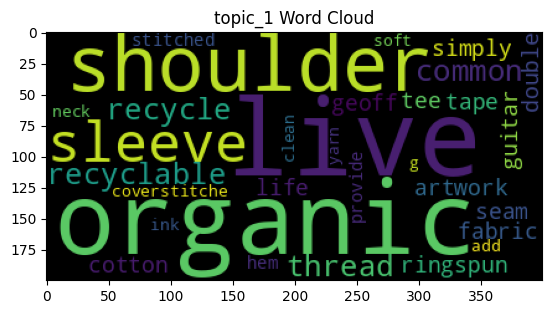

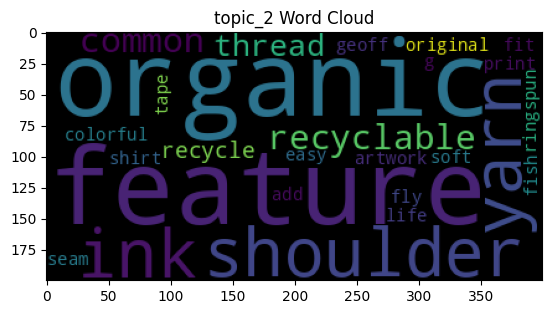

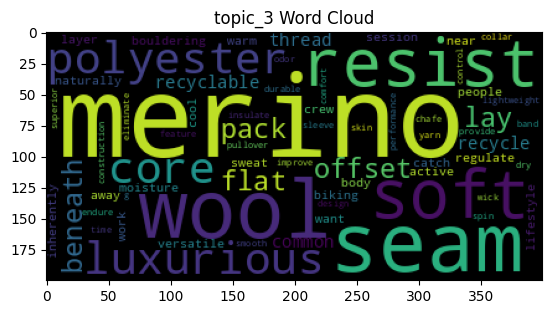

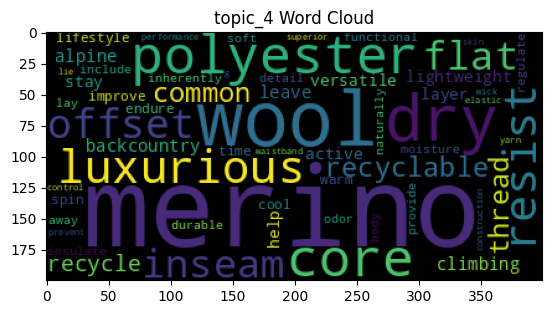

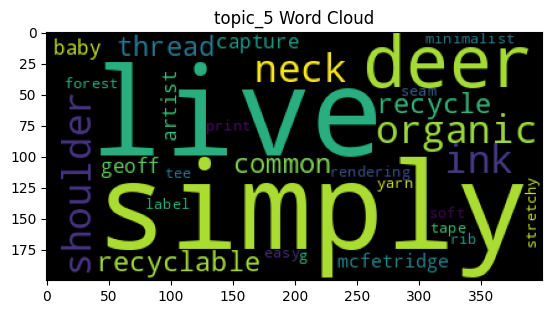

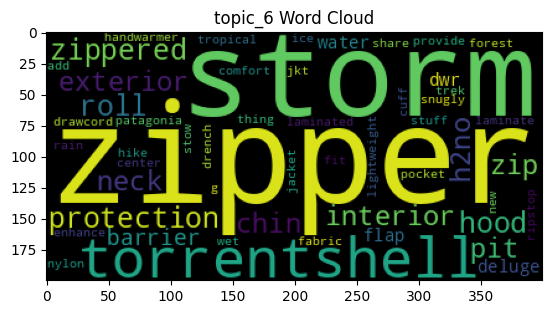

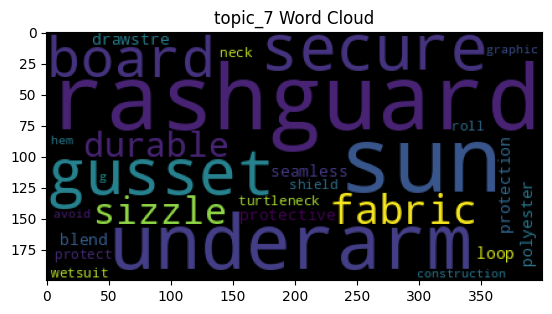

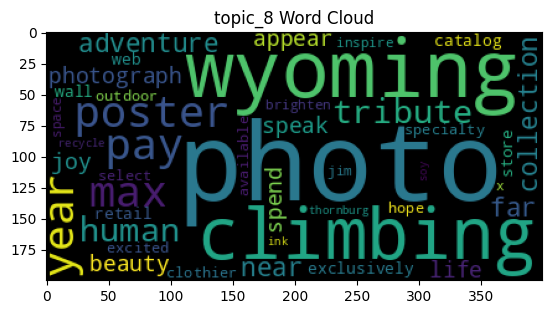

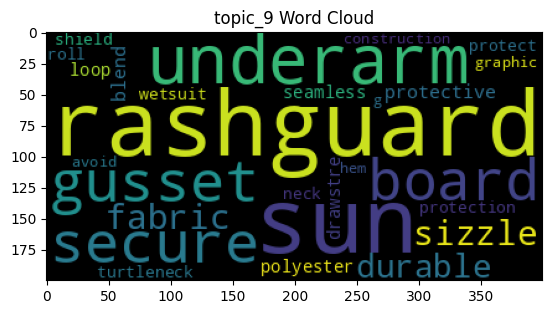

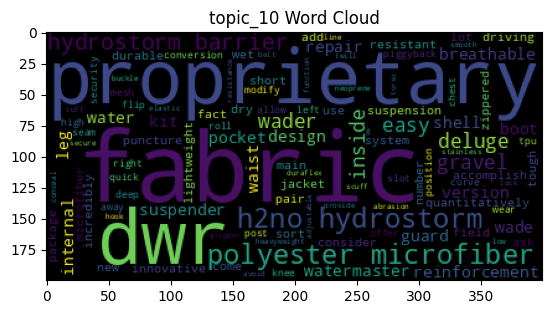

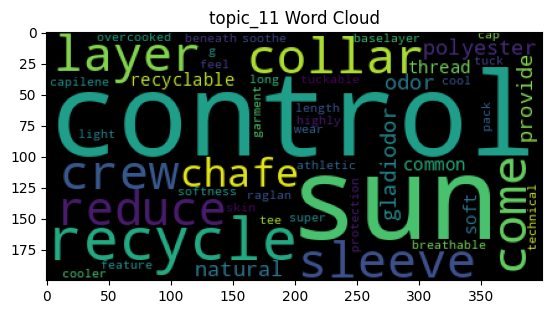

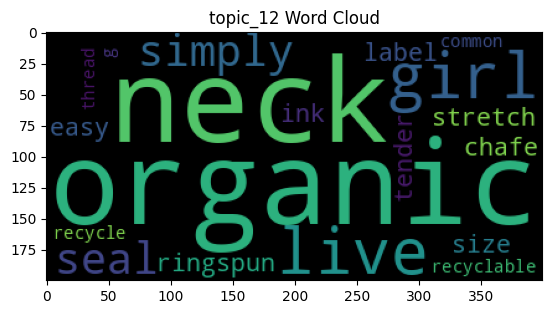

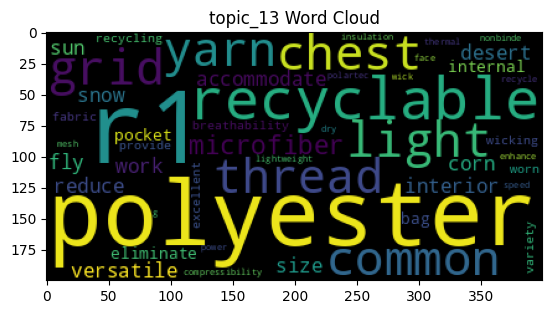

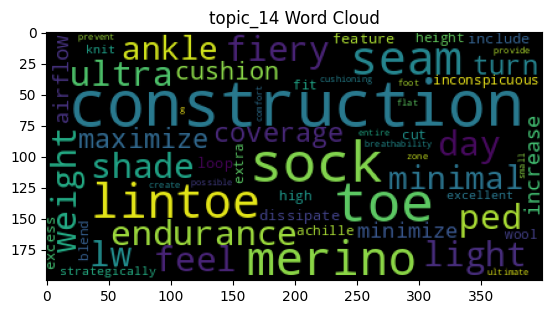

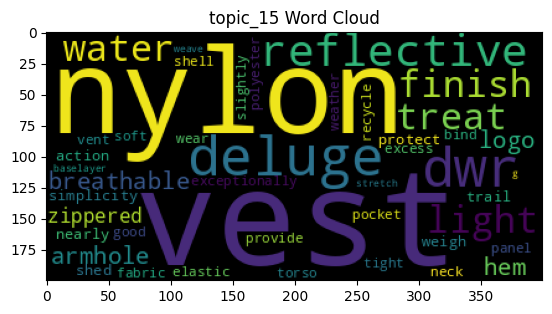

In [238]:
topics_columns_list = ['topic_'  + str(x) for x in range(1,16)]

for i in topics_columns_list:
  index_max_value = topic_encoded_df[i].idxmax()
  topic_text = topic_encoded_df.loc[index_max_value, 'clean_token']
  cloud = wd.generate(topic_text)
  plt.title(f'{i} Word Cloud')
  plt.imshow(cloud)
  plt.show()